In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

df1 = pd.read_csv("data/dev101_prepared.csv")
df2 = pd.read_csv("data/dev102_prepared.csv")

In [25]:
df_all = pd.concat([df1, df2], ignore_index=True)
df_all.describe()

,devID,soil,rain,temp,humi,geo,unixt,lat,lng,rain_1h_sum,...,soil_1d_mean,geo_1h_mean,geo_3h_mean,geo_6h_mean,geo_12h_mean,geo_1d_mean,soil_diff,geo_diff,soil_1h_std,geo_1h_std
count,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,1.644660e+05,164466.000000,164466.000000,164466.000000,...,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000
mean,101.513589,53.776477,0.092247,29.679459,75.856262,8.072711,1.748035e+09,8.638065,99.895333,22.694812,...,53.812939,8.097669,8.122717,8.131706,8.175906,8.198281,0.000104,0.000033,0.212697,4.609207
std,0.499817,5.954348,0.531029,3.033125,7.862898,6.715461,1.293685e+06,0.105605,0.599403,102.214009,...,5.240015,4.122324,4.070308,4.072700,4.071846,4.078390,0.133532,6.907295,0.443326,2.718295
min,101.000000,30.000000,0.000000,24.949266,49.724041,0.000000,1.746233e+09,0.083333,0.008333,0.000000,...,29.900000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.700001,-31.521689,0.000000,0.000000
25%,101.000000,49.000000,0.000000,27.376595,70.564049,3.513890,1.746515e+09,8.637946,99.898933,0.000000,...,49.735621,4.111799,4.162901,4.399856,4.500379,4.567634,0.000000,-1.213978,0.074960,2.586407
50%,102.000000,53.900002,0.000000,28.236437,79.402840,4.111144,1.748635e+09,8.637970,99.898949,0.000000,...,53.189763,7.388593,7.084110,6.836436,6.539413,6.302564,0.000000,0.000000,0.110629,4.458970
75%,102.000000,58.599998,0.000000,32.188526,81.222481,12.619162,1.749138e+09,8.638009,99.898972,0.000000,...,57.998910,11.348028,11.516647,11.571721,11.748648,11.254114,0.000000,1.184657,0.212783,6.460629
max,102.000000,65.500000,7.264400,38.984512,88.510567,32.062466,1.749750e+09,48.859433,99.899544,1434.998409,...,63.666010,31.989561,31.989561,31.989561,31.989561,31.989561,13.299999,31.505789,7.738690,12.330683


In [26]:
#feature_cols = [
#    'soil', 'rain', 'temp', 'humi', 'geo',
#    'rain_1h_sum', 'rain_3h_sum', 'rain_6h_sum', 'rain_12h_sum', 'rain_1d_sum', 'rain_7d_sum',
#    'soil_1h_mean', 'soil_3h_mean', 'soil_6h_mean', 'soil_12h_mean', 'soil_1d_mean',
#    'geo_1h_mean', 'geo_3h_mean', 'geo_6h_mean', 'geo_12h_mean', 'geo_1d_mean',
#    'soil_diff', 'geo_diff', 'soil_1h_std', 'geo_1h_std'
#]

feature_cols = [
    'soil', 'rain', 'temp', 'humi', 'geo',
]

#feature_cols = [
#    'soil', 'rain', 'temp', 'humi', 'geo',
#    'rain_1h_sum', 'rain_3h_sum', 'rain_6h_sum', 'rain_12h_sum',
#    'soil_1h_mean', 'soil_3h_mean', 'soil_6h_mean', 'soil_12h_mean',
#    'geo_1h_mean', 'geo_3h_mean', 'geo_6h_mean', 'geo_12h_mean',
#]

In [27]:
missing = [col for col in feature_cols if col not in df_all.columns]
if missing:
    raise ValueError(f"ขาดคอลัมน์ในข้อมูลทั้งหมด: {missing}")

In [28]:
df_train, df_temp = train_test_split(df_all, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.35, random_state=42)

print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

X_train = df_train[feature_cols].values
X_val = df_val[feature_cols].values
X_test = df_test[feature_cols].values

Train: 131572, Validation: 21381, Test: 11513


In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled = X_train
#X_val_scaled = X_val
#X_test_scaled = X_test

In [30]:
iso_model = IsolationForest(n_estimators=50, contamination=0.03, random_state=42)
iso_model.fit(X_train_scaled)

IsolationForest(contamination=0.03, n_estimators=50, random_state=42)

In [31]:
df_train['anomaly_score'] = iso_model.decision_function(X_train_scaled)
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
df_test['anomaly_score'] = iso_model.decision_function(X_test_scaled)

In [32]:
#crit_thresh = np.percentile(df_train['anomaly_score'], 1)
#warn_thresh = np.percentile(df_train['anomaly_score'], 10)

crit_thresh = -0.1
warn_thresh = 0.00

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

for df in [df_train, df_val, df_test]:
    df['risk_level'] = df['anomaly_score'].apply(classify_risk)

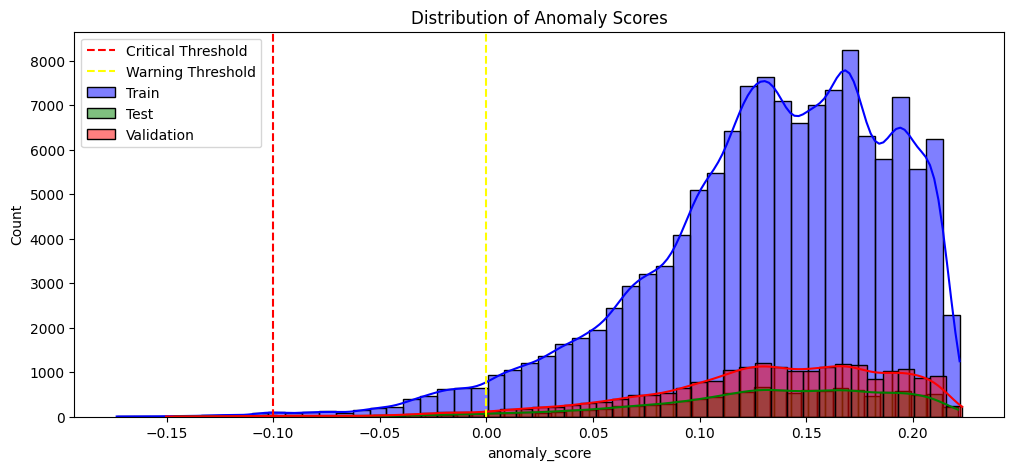

In [33]:

plt.figure(figsize=(12,5))
sns.histplot(df_train['anomaly_score'], bins=50, kde=True, color='blue', label='Train')
sns.histplot(df_test['anomaly_score'], bins=50, kde=True, color='green', label='Test')
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='red', label='Validation')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()


In [34]:
print(df_train['risk_level'].value_counts(normalize=True))
print(df_test['risk_level'].value_counts(normalize=True))
print(df_val['risk_level'].value_counts(normalize=True))

risk_level
Normal      0.969994
Warning     0.028243
Critical    0.001763
Name: proportion, dtype: float64
risk_level
Normal      0.970729
Warning     0.027882
Critical    0.001390
Name: proportion, dtype: float64
risk_level
Normal      0.971938
Warning     0.025630
Critical    0.002432
Name: proportion, dtype: float64


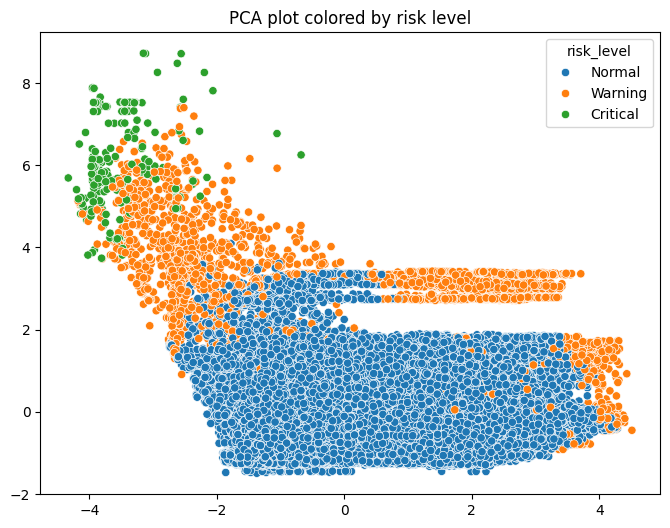

In [35]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_train['risk_level'])
plt.title('PCA plot colored by risk level')
plt.show()


In [36]:
# ดูว่าแต่ละ feature มีน้ำหนักกับแต่ละ principal component เท่าไหร่ x=PC1 y=PC2
pca_df = pd.DataFrame(pca.components_, columns=feature_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))  # เรียงตามผลต่อแกน X


           PC1       PC2
temp  0.674379  0.022140
geo   0.002021  0.854774
rain -0.188843  0.429158
soil -0.246833 -0.290814
humi -0.669791  0.011044


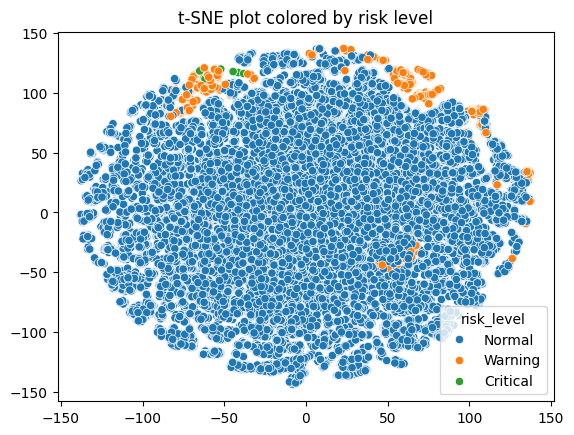

In [37]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df_train['risk_level'])
plt.title('t-SNE plot colored by risk level')
plt.show()

C:\Users\ahmad\AppData\Local\Temp\ipykernel_13716\1129453054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_all_labeled, x='risk_level', order=['Normal', 'Warning', 'Critical'], palette='Set2')


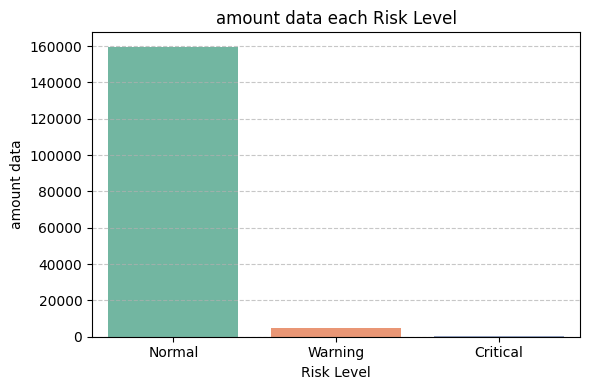

In [38]:
df_all_labeled = pd.concat([df_train, df_val, df_test], ignore_index=True)

plt.figure(figsize=(6, 4))
sns.countplot(data=df_all_labeled, x='risk_level', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [39]:
df_all_labeled['risk_level'].value_counts()

risk_level
Normal      159581
Warning       4585
Critical       300
Name: count, dtype: int64

In [40]:
df_all_labeled['risk_level'].value_counts(normalize=True) * 100  # คูณ 100 เพื่อเป็น %


risk_level
Normal      97.029781
Warning      2.787810
Critical     0.182409
Name: proportion, dtype: float64

In [41]:
df_all_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164466 entries, 0 to 164465
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp      164466 non-null  object 
 1   devID          164466 non-null  float64
 2   soil           164466 non-null  float64
 3   rain           164466 non-null  float64
 4   temp           164466 non-null  float64
 5   humi           164466 non-null  float64
 6   geo            164466 non-null  float64
 7   unixt          164466 non-null  float64
 8   lat            164466 non-null  float64
 9   lng            164466 non-null  float64
 10  rain_1h_sum    164466 non-null  float64
 11  rain_3h_sum    164466 non-null  float64
 12  rain_6h_sum    164466 non-null  float64
 13  rain_12h_sum   164466 non-null  float64
 14  rain_1d_sum    164466 non-null  float64
 15  rain_7d_sum    164466 non-null  float64
 16  soil_1h_mean   164466 non-null  float64
 17  soil_3h_mean   164466 non-nul

Text(0.5, 1.0, 'Anomaly Score over Time devID 101')

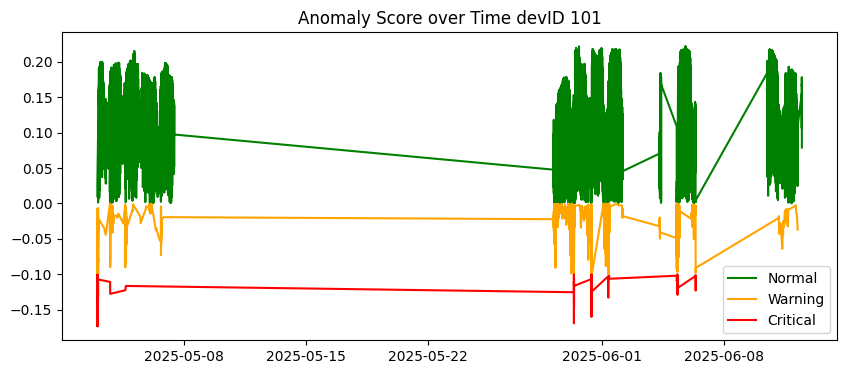

In [42]:
df_dev = df_all_labeled[df_all_labeled['devID'] == 101].copy()
df_dev['timestamp'] = pd.to_datetime(df_dev['timestamp'])
df_dev = df_dev.set_index('timestamp').sort_index()

plt.figure(figsize=(10,4))
for level, color in {'Normal':'green','Warning':'orange','Critical':'red'}.items():
    df_sub = df_dev[df_dev['risk_level']==level]
    plt.plot(df_sub.index, df_sub['anomaly_score'], linestyle='-', marker=None, color=color, label=level)
plt.legend(); plt.title("Anomaly Score over Time devID 101")


Text(0.5, 1.0, 'Anomaly Score over Time devID 102')

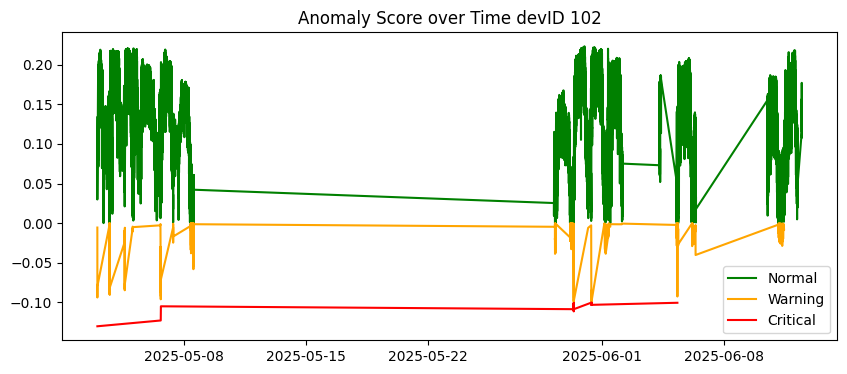

In [43]:
df_dev = df_all_labeled[df_all_labeled['devID'] == 102].copy()
df_dev['timestamp'] = pd.to_datetime(df_dev['timestamp'])
df_dev = df_dev.set_index('timestamp').sort_index()

plt.figure(figsize=(10,4))
for level, color in {'Normal':'green','Warning':'orange','Critical':'red'}.items():
    df_sub = df_dev[df_dev['risk_level']==level]
    plt.plot(df_sub.index, df_sub['anomaly_score'], linestyle='-', marker=None, color=color, label=level)
plt.legend(); plt.title("Anomaly Score over Time devID 102")


C:\Users\ahmad\AppData\Local\Temp\ipykernel_13716\2630523206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


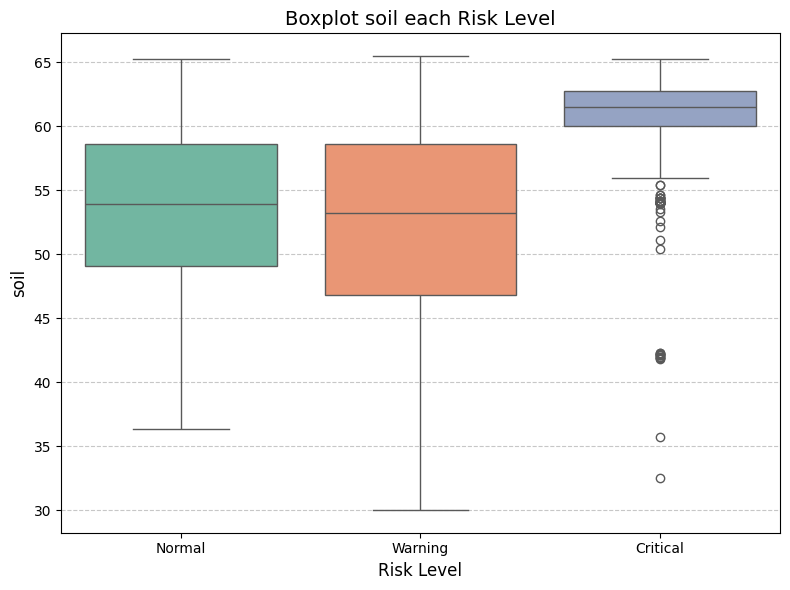

C:\Users\ahmad\AppData\Local\Temp\ipykernel_13716\2630523206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


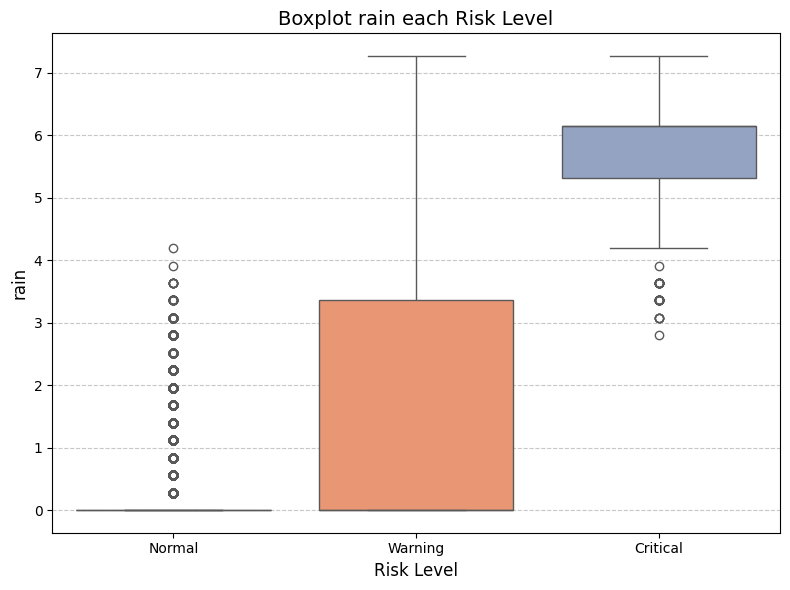

C:\Users\ahmad\AppData\Local\Temp\ipykernel_13716\2630523206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


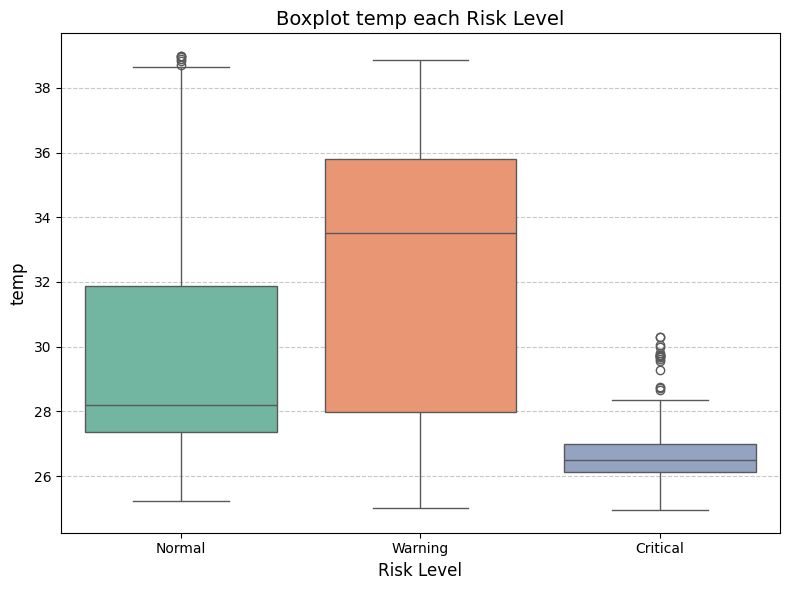

C:\Users\ahmad\AppData\Local\Temp\ipykernel_13716\2630523206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


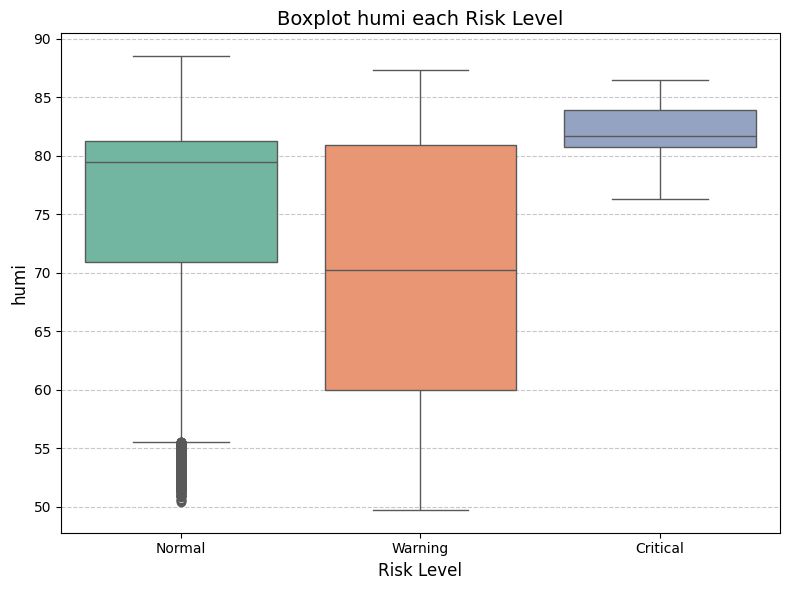

C:\Users\ahmad\AppData\Local\Temp\ipykernel_13716\2630523206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


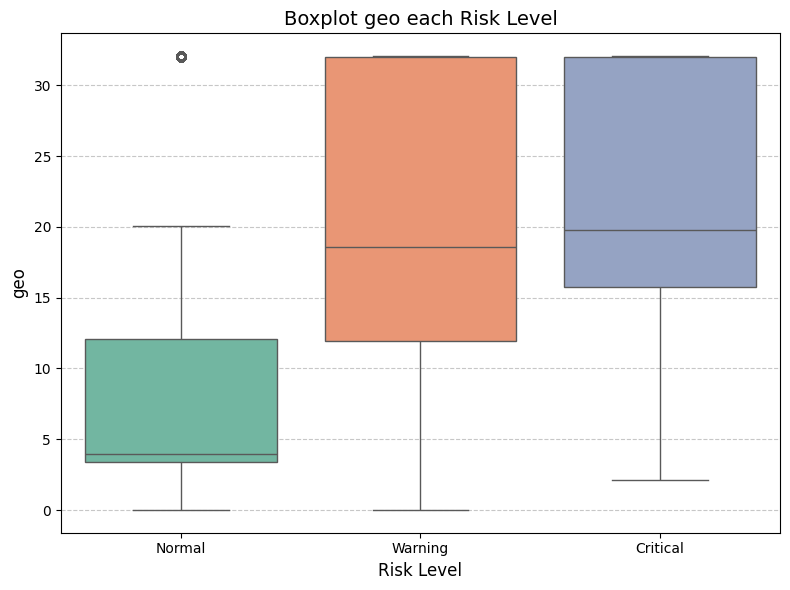

Create Box Plot for every Feature successfully!


In [44]:
for feature in feature_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_all_labeled, x='risk_level', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


    plt.title(f'Boxplot {feature} each Risk Level', fontsize=14)
    plt.xlabel('Risk Level', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Create Box Plot for every Feature successfully!")

In [45]:
from joblib import dump
dump(scaler, 'model/iso_scaler.joblib')
dump(iso_model, 'model/iso_model.joblib')

['model/iso_model.joblib']

In [46]:
"""

from joblib import load
scaler = load('scaler.joblib')
model = load('iso_model.joblib')

x_new = scaler.transform([[soil, rain, temp, humi, geo]])
score = model.decision_function(x_new)

if score < -0.2:
    risk = "Critical"
elif score < 0.0:
    risk = "Warning"
else:
    risk = "Normal"
    
    """

'\n\nfrom joblib import load\nscaler = load(\'scaler.joblib\')\nmodel = load(\'iso_model.joblib\')\n\nx_new = scaler.transform([[soil, rain, temp, humi, geo]])\nscore = model.decision_function(x_new)\n\nif score < -0.2:\n    risk = "Critical"\nelif score < 0.0:\n    risk = "Warning"\nelse:\n    risk = "Normal"\n    \n    '